In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
full_data = pd.read_csv("../../data/processed/historical/train/lcl_data.csv")
df_100K = full_data.sample(100000, random_state=0)
df_100K.to_csv("../../data/processed/historical/train/lcl_data_100K.csv", index=False)

# Load Data

In [3]:
import torch
import numpy as np
import random
RANDOM_STATE = 0
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(RANDOM_STATE)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [4]:
from pathlib import Path
from opensynth.data_modules.lcl_data_module import LCLDataModule
import pytorch_lightning as pl

import matplotlib.pyplot as plt

data_path = Path("../../data/processed/historical/train/lcl_data_100K.csv")
stats_path = Path("../../data/processed/historical/train/mean_std.csv")
outlier_path = Path("../../data/processed/historical/train/outliers.csv")

dm = LCLDataModule(data_path=data_path, stats_path=stats_path, batch_size=25000, n_samples=100000)
dm.setup()

In [5]:
import torch
from opensynth.models.faraday import FaradayVAE
vae_model = torch.load("vae_model.pt")
vae_model.eval()

FaradayVAE(
  (encoder): Encoder(
    (encoder_layers): Sequential(
      (0): Linear(in_features=50, out_features=512, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): GELU(approximate='none')
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): GELU(approximate='none')
      (8): Linear(in_features=64, out_features=32, bias=True)
      (9): GELU(approximate='none')
      (10): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (latent): Linear(in_features=18, out_features=16, bias=True)
    (latent_activations): GELU(approximate='none')
    (decoder_layers): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): GELU(approximate='no

In [6]:
from opensynth.models.faraday.gaussian_mixture.prepare_gmm_input import encode_data_for_gmm

next_batch = next(iter(dm.train_dataloader()))
input_tensor = encode_data_for_gmm(data=next_batch, vae_module=vae_model)
input_data = input_tensor.detach().numpy()
n_samples = len(input_tensor)

In [7]:
N_COMPONENTS = 700
REG_COVAR = 1e-4
EPOCHS = 25
IDX = 0
CONVERGENCE_TOL = 1e-2


In [8]:
input_tensor.shape, input_tensor[0][0]

(torch.Size([25000, 18]), tensor(0.4973, grad_fn=<SelectBackward0>))

# Init GMM

In [9]:
from opensynth.models.faraday.new_gmm import gmm_utils

labels_, means_, responsibilities_ = gmm_utils.initialise_centroids(
        X=input_data, n_components=N_COMPONENTS
    )
print(labels_.dtype, responsibilities_.dtype, means_.dtype)

torch.float32 torch.float32 torch.float32


In [10]:
from opensynth.models.faraday.new_gmm.train_gmm import initialise_gmm_params

gmm_init_params = initialise_gmm_params(
    X=input_data,
    n_components = N_COMPONENTS,
    reg_covar=REG_COVAR,
)
print(gmm_init_params["precision_cholesky"][IDX][0][0])
print(gmm_init_params["weights"].sum())

tensor(6.6420)
tensor(1.)


# Torch GMM

In [11]:
from opensynth.models.faraday.new_gmm.train_gmm import initialise_gmm_params, training_loop
from opensynth.models.faraday.new_gmm.new_gmm_model import GaussianMixtureModel


gmm_init_params = initialise_gmm_params(
    X=input_data,
    n_components = N_COMPONENTS,
    reg_covar=REG_COVAR,
)

means = gmm_init_params["means"].detach().numpy()
weights = gmm_init_params["weights"].detach().numpy()
prec_chol = gmm_init_params["precision_cholesky"].detach().numpy()
print(f"Initial prec chol: {prec_chol[IDX][0][0]}. Initial mean: {means[IDX][0]}")

torch_gmm = GaussianMixtureModel(
    num_components=N_COMPONENTS,
    num_features = input_data.shape[1],
    reg_covar=REG_COVAR,
    print_idx=IDX
)
torch_gmm.initialise(gmm_init_params)
trained_model, log_prob_epochs = training_loop(model=torch_gmm, data=input_tensor, max_iter=EPOCHS)

Initial prec chol: 6.642029285430908. Initial mean: -0.11744648963212967


  4%|▍         | 1/25 [00:02<01:06,  2.78s/it]

log prob:  tensor(-1.7353, grad_fn=<NegBackward0>)


  8%|▊         | 2/25 [00:05<01:05,  2.87s/it]

log prob:  tensor(-2.1089, grad_fn=<NegBackward0>)


 12%|█▏        | 3/25 [00:08<00:57,  2.62s/it]

log prob:  tensor(-2.3179, grad_fn=<NegBackward0>)


 16%|█▌        | 4/25 [00:10<00:52,  2.50s/it]

log prob:  tensor(-2.4595, grad_fn=<NegBackward0>)


 20%|██        | 5/25 [00:12<00:50,  2.54s/it]

log prob:  tensor(-2.5652, grad_fn=<NegBackward0>)


 24%|██▍       | 6/25 [00:15<00:49,  2.62s/it]

log prob:  tensor(-2.6564, grad_fn=<NegBackward0>)


 28%|██▊       | 7/25 [00:18<00:48,  2.69s/it]

log prob:  tensor(-2.7336, grad_fn=<NegBackward0>)


 32%|███▏      | 8/25 [00:21<00:46,  2.74s/it]

log prob:  tensor(-2.7934, grad_fn=<NegBackward0>)


 36%|███▌      | 9/25 [00:24<00:45,  2.86s/it]

log prob:  tensor(-2.8381, grad_fn=<NegBackward0>)


 40%|████      | 10/25 [00:27<00:45,  3.00s/it]

log prob:  tensor(-2.8720, grad_fn=<NegBackward0>)


 44%|████▍     | 11/25 [00:31<00:44,  3.16s/it]

log prob:  tensor(-2.8965, grad_fn=<NegBackward0>)


 48%|████▊     | 12/25 [00:34<00:41,  3.21s/it]

log prob:  tensor(-2.9157, grad_fn=<NegBackward0>)


 52%|█████▏    | 13/25 [00:37<00:37,  3.15s/it]

log prob:  tensor(-2.9323, grad_fn=<NegBackward0>)


 56%|█████▌    | 14/25 [00:41<00:37,  3.43s/it]

log prob:  tensor(-2.9483, grad_fn=<NegBackward0>)


 60%|██████    | 15/25 [00:44<00:32,  3.23s/it]

log prob:  tensor(-2.9611, grad_fn=<NegBackward0>)


 64%|██████▍   | 16/25 [00:47<00:27,  3.08s/it]

log prob:  tensor(-2.9725, grad_fn=<NegBackward0>)


 68%|██████▊   | 17/25 [00:49<00:23,  2.90s/it]

log prob:  tensor(-2.9835, grad_fn=<NegBackward0>)


 68%|██████▊   | 17/25 [00:52<00:24,  3.08s/it]

log prob:  tensor(-2.9934, grad_fn=<NegBackward0>)
Converged: True. Number of iterations: 17


# SK Learn GMM Manual

In [12]:
import numpy as np
from scipy.special import logsumexp
from scipy import linalg

def is_symmetric_positive_definite(covariance):
    is_symmetric = np.all([np.allclose(covariance[i], covariance[i].T) for i in range(covariance.shape[0])])
    is_positive_definite = np.all([np.all(np.linalg.eigvalsh(covariance[i]) > 0.0) for i in range(covariance.shape[0])])
    return is_symmetric and is_positive_definite

def _estimate_gaussian_parameters(X, resp, reg_covar=REG_COVAR):
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    means = np.dot(resp.T, X) / nk[:, np.newaxis]
    n_components, n_features = means.shape
    covariances = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        diff = X - means[k]
        covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
        covariances[k].flat[:: n_features + 1] += reg_covar

    check_covariances = is_symmetric_positive_definite(covariances)
    if not check_covariances:
        raise ValueError("Covariance matrix is not positive definite.")
    return nk, means, covariances

def _compute_precision_cholesky(covariances):
    estimate_precision_error_message = (
        "Fitting the mixture model failed because some components have "
        "ill-defined empirical covariance (for instance caused by singleton "
        "or collapsed samples). Try to decrease the number of components, "
        "or increase reg_covar."
    )

    n_components, n_features, _ = covariances.shape
    precisions_chol = np.empty((n_components, n_features, n_features))
    for k, covariance in enumerate(covariances):
        try:
            cov_chol = linalg.cholesky(covariance, lower=True)
        except linalg.LinAlgError:
            raise ValueError(estimate_precision_error_message)
        precisions_chol[k] = linalg.solve_triangular(
            cov_chol, np.eye(n_features), lower=True
        ).T
    return precisions_chol

def _compute_log_det_cholesky(matrix_chol, n_features):
    n_components, _, _ = matrix_chol.shape
    log_det_chol = np.sum(
        np.log(matrix_chol.reshape(n_components, -1)[:, :: n_features + 1]), 1
    )
    return log_det_chol

def _estimate_log_gaussian_prob(X, means, precisions_chol):
    n_samples, n_features = X.shape
    n_components, _ = means.shape

    log_det = _compute_log_det_cholesky(precisions_chol, n_features)

    log_prob = np.empty((n_samples, n_components))
    for k, (mu, prec_chol) in enumerate(zip(means, precisions_chol)):
        y = np.dot(X, prec_chol) - np.dot(mu, prec_chol)
        log_prob[:, k] = np.sum(np.square(y), axis=1)
    return -0.5 * (n_features * np.log(2 * np.pi) + log_prob) + log_det

def _estimate_log_weights(weights):
        return np.log(weights)

def _estimate_weighted_log_prob(X, means, precisions_chol, weights):
        return _estimate_log_gaussian_prob(X, means, precisions_chol) + _estimate_log_weights(weights)


def _estimate_log_prob_resp(X, means, precisions_chol, weights):
    weighted_log_prob = _estimate_weighted_log_prob(X, means, precisions_chol, weights)
    log_prob_norm = logsumexp(weighted_log_prob, axis=1)
    with np.errstate(under="ignore"):
        log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
    return log_prob_norm, log_resp

def _e_step(X,means, precisions_chol, weights):
    log_prob_norm, log_resp = _estimate_log_prob_resp(X, means, precisions_chol, weights)
    return np.mean(log_prob_norm), log_resp

def _m_step(X, log_reponsibilities, reg_covar=REG_COVAR):

    weights_, means_, covariances_ = _estimate_gaussian_parameters(X,np.exp(log_reponsibilities),reg_covar=reg_covar)
    weights_ /= weights_.sum()

    precision_cholesky_ = _compute_precision_cholesky(covariances=covariances_)

    return precision_cholesky_, weights_, means_, covariances_

In [13]:
means = gmm_init_params["means"].detach().numpy()
weights = gmm_init_params["weights"].detach().numpy()
prec_chol = gmm_init_params["precision_cholesky"].detach().numpy()

print(f"Initial prec chol: {prec_chol[IDX][0][0]}. Initial mean: {means[IDX][0]}")

converged = False
lower_bound = -np.inf
np_log_prob_epochs = []
for i in range(EPOCHS):
    prev_lower_bound = lower_bound

    print(f"Old Prec Chol: {prec_chol[IDX][0][0]}. Old means: {means[IDX][0]}")
    log_prob, log_resp = _e_step(input_data, means, prec_chol, weights)
    prec_chol, weights, means, covar = _m_step(input_data, log_resp)

    print(f"New prec chol: {prec_chol[IDX][0][0]}. New means: {means[IDX][0]}")

    # Converegence
    lower_bound = -log_prob
    change = abs(lower_bound - prev_lower_bound)
    print(f"log prob: {log_prob}, change: {change}")
    np_log_prob_epochs.append(lower_bound)
    if change < CONVERGENCE_TOL:
        converged = True
        break

print(f'Converged: {converged}. Number of iterations: {i}')

Initial prec chol: 6.642029285430908. Initial mean: -0.11744648963212967
Old Prec Chol: 6.642029285430908. Old means: -0.11744648963212967
New prec chol: 6.432963578683903. New means: -0.13688528732254718
log prob: 1.735338299854014, change: inf
Old Prec Chol: 6.432963578683903. Old means: -0.13688528732254718
New prec chol: 6.423680953707583. New means: -0.15136358003929168
log prob: 2.108812957430841, change: 0.3734746575768271
Old Prec Chol: 6.423680953707583. Old means: -0.15136358003929168
New prec chol: 6.537481563374545. New means: -0.161987004486275
log prob: 2.3177299763142356, change: 0.20891701888339442
Old Prec Chol: 6.537481563374545. Old means: -0.161987004486275
New prec chol: 6.631282302442071. New means: -0.1674405691472452
log prob: 2.45929037554233, change: 0.14156039922809427
Old Prec Chol: 6.631282302442071. Old means: -0.1674405691472452
New prec chol: 6.648750994180154. New means: -0.16985654740635123
log prob: 2.564971648966961, change: 0.10568127342463107
Old P

In [14]:
import matplotlib.pyplot as plt

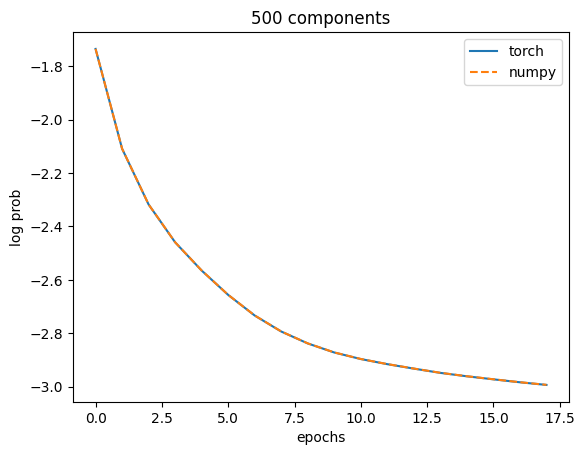

In [ ]:
torch_log_prob_epochs = [log_prob.detach().item() for log_prob in log_prob_epochs]
plt.plot(np.arange(0, i+1), torch_log_prob_epochs, label='torch')
plt.plot(np.arange(0, i+1), np_log_prob_epochs, label='numpy', linestyle='--')
plt.xlabel('epochs')
plt.ylabel('log prob')
plt.title('500 components')
plt.legend()
plt.show()

# SK Learn GMM Epoch

In [17]:
from sklearn.mixture import GaussianMixture

init_weights = gmm_init_params["weights"]
init_means = gmm_init_params["means"]

skgmm = GaussianMixture(n_components=N_COMPONENTS, covariance_type='full', tol=CONVERGENCE_TOL, max_iter=EPOCHS, random_state=0, means_init = init_means, weights_init=init_weights, verbose=2, verbose_interval=1)
skgmm.fit(input_data)
skgmm_pred = skgmm.predict(input_data)

Initialization 0
  Iteration 1	 time lapse 12.56763s	 ll change inf
  Iteration 2	 time lapse 6.11678s	 ll change 0.39296
  Iteration 3	 time lapse 6.40847s	 ll change 0.21495
  Iteration 4	 time lapse 6.80483s	 ll change 0.14734
  Iteration 5	 time lapse 6.41462s	 ll change 0.10943
  Iteration 6	 time lapse 6.53152s	 ll change 0.09462
  Iteration 7	 time lapse 7.16391s	 ll change 0.07798
  Iteration 8	 time lapse 6.39741s	 ll change 0.06258
  Iteration 9	 time lapse 6.58530s	 ll change 0.04706
  Iteration 10	 time lapse 7.47697s	 ll change 0.03431
  Iteration 11	 time lapse 7.17728s	 ll change 0.02518
  Iteration 12	 time lapse 5.82799s	 ll change 0.02044
  Iteration 13	 time lapse 5.33615s	 ll change 0.01895
  Iteration 14	 time lapse 5.03128s	 ll change 0.01658
  Iteration 15	 time lapse 5.36255s	 ll change 0.01540
  Iteration 16	 time lapse 5.06910s	 ll change 0.01316
  Iteration 17	 time lapse 5.21010s	 ll change 0.01053
  Iteration 18	 time lapse 5.35777s	 ll change 0.00982
Initi

In [18]:
skgmm.converged_, skgmm.n_iter_

(True, 18)

# Torch Lightning

In [19]:
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningDataModule
class CustomDataset(Dataset):
    def __init__(self, data_tensor: torch.Tensor):
        self.data = data_tensor
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    
class CustomDataModule(LightningDataModule):
    def __init__(self, data_tensor: torch.Tensor, batch_size: int):
        super().__init__()
        self.data_tensor = data_tensor
        self.batch_size = batch_size
    def setup(self, stage=""):
        self.custom_ds = CustomDataset(self.data_tensor)
    def train_dataloader(self):
        return DataLoader(self.custom_ds, batch_size=self.batch_size, shuffle=False, generator=g, worker_init_fn=seed_worker)
    
custom_dm = CustomDataModule(data_tensor=input_tensor, batch_size=25000)
custom_dm.setup(stage="")

In [20]:

for i in range(5):
    print(next(iter(custom_dm.train_dataloader()))[0][0])

tensor(0.4973, grad_fn=<SelectBackward0>)
tensor(0.4973, grad_fn=<SelectBackward0>)
tensor(0.4973, grad_fn=<SelectBackward0>)
tensor(0.4973, grad_fn=<SelectBackward0>)
tensor(0.4973, grad_fn=<SelectBackward0>)


In [ ]:
from opensynth.models.faraday.new_gmm.new_gmm_model import GaussianMixtureLightningModule, GaussianMixtureModel
gmm_module = GaussianMixtureModel(
    num_components=N_COMPONENTS,
    num_features = input_data.shape[1],
    reg_covar=REG_COVAR,
    print_idx=IDX
)
gmm_module.initialise(gmm_init_params)
print(f"Initial prec chol: {gmm_module.precision_cholesky[IDX][0][0]}. Initial mean: {gmm_module.means[IDX][0]}")

gmm_lightning_module = GaussianMixtureLightningModule(
    gmm_module = gmm_module,
    vae_module = vae_model,
    num_components = gmm_module.num_components,
    num_features = gmm_module.num_features,
    reg_covar = gmm_module.reg_covar,
    convergence_tolerance = CONVERGENCE_TOL,
    sync_on_batch=False
)
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator="cpu", deterministic=True )
trainer.fit(gmm_lightning_module, custom_dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/core/opt

Initial prec chol: 6.642029285430908. Initial mean: -0.11744648963212967


/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/charlotte.avery/.virtualenvs/OpenSynth-BNsxhSIM/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.49it/s, v_num=90]Local weights at rank: 0 - means: 0.0055, -0.1369
Reduced weights, means, covar: 0.0055, -0.1369, 0.0242
log prob:  tensor(-1.7353)
Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  0.62it/s, v_num=90]Local weights at rank: 0 - means: 0.0061, -0.1514
Reduced weights, means, covar: 0.0061, -0.1514, 0.0242
log prob:  tensor(-2.1089)
Epoch 2: 100%|██████████| 1/1 [00:01<00:00,  0.62it/s, v_num=90]Local weights at rank: 0 - means: 0.0064, -0.1620
Reduced weights, means, covar: 0.0064, -0.1620, 0.0234
log prob:  tensor(-2.3179)
Epoch 3: 100%|██████████| 1/1 [00:01<00:00,  0.69it/s, v_num=90]Local weights at rank: 0 - means: 0.0066, -0.1674
Reduced weights, means, covar: 0.0066, -0.1674, 0.0227
log prob:  tensor(-2.4595)
Epoch 4: 100%|██████████| 1/1 [00:01<00:00,  0.75it/s, v_num=90]Local weights at rank: 0 - means: 0.0066, -0.1699
Reduced weights, means, covar: 0.0066, -0.1699, 0.0226
log prob:  tensor(-2.5652)
Epoch 5: 100%|██████

In [22]:
gmm_lightning_module.weight_metric.compute()[0], gmm_lightning_module.mean_metric.compute()[0][0]

(tensor(0.0053), tensor(-0.2124))

# Compare

In [23]:
IDX = 0

In [24]:
df_compare_means = pd.DataFrame()
df_compare_means["skgmm"] = skgmm.means_[IDX]
df_compare_means["numpy"] = means[IDX]
df_compare_means["torch"] = trained_model.means[IDX]
df_compare_means["lightning"] = gmm_lightning_module.gmm_module.means[IDX]
df_compare_means

,skgmm,numpy,torch,lightning
0,-0.177812,-0.212716,-0.212372,-0.212372
1,-2.630335,-2.505732,-2.505953,-2.505953
2,0.244407,0.219610,0.218786,0.218786
3,0.060124,0.126913,0.127881,0.127881
4,-0.049596,-0.020005,-0.020234,-0.020234
5,-0.029421,-0.061361,-0.061332,-0.061332
6,0.387513,0.331236,0.330309,0.330309
7,2.323282,2.380669,2.381529,2.381529
8,-0.012398,-0.012253,-0.012595,-0.012595
9,-2.338854,-2.501915,-2.501398,-2.501398


In [25]:
gmm_init_params["means"][IDX]

tensor([-1.1745e-01, -2.6930e+00,  1.3211e-01,  2.0796e-01,  8.0334e-02,
        -4.6100e-03,  2.8707e-01,  2.2114e+00, -2.9962e-02, -2.3726e+00,
         3.7961e-01,  4.0148e-01, -4.9165e-03,  7.3653e-01,  1.4565e+00,
        -2.3367e+00,  4.8403e+00,  5.3782e-01])

In [26]:
df_compare_covar = pd.DataFrame()
df_compare_covar["skgmm"] = skgmm.covariances_[IDX][0]
df_compare_covar["numpy"] = covar[IDX][0]
df_compare_covar["torch"] = trained_model.covariances.detach().numpy()[IDX][0]
df_compare_covar["lightning"] = gmm_lightning_module.gmm_module.covariances.detach().numpy()[IDX][0]
df_compare_covar

,skgmm,numpy,torch,lightning
0,0.022647,0.022885,0.022873,0.022873
1,-0.066062,-0.070538,-0.070572,-0.070572
2,-0.031553,-0.037055,-0.036989,-0.036989
3,0.034193,0.040163,0.040070,0.040070
4,0.005880,0.002422,0.002553,0.002553
5,0.008600,0.007099,0.007122,0.007122
6,-0.025484,-0.032502,-0.032373,-0.032373
7,0.024867,0.038144,0.037946,0.037946
8,-0.008028,-0.010404,-0.010352,-0.010352
9,0.001745,-0.009538,-0.009610,-0.009610


In [27]:
df_compare_pre_chol = pd.DataFrame()
df_compare_pre_chol["skgmm"] = skgmm.precisions_cholesky_[IDX][0]
df_compare_pre_chol["numpy"] = prec_chol[IDX][0]
df_compare_pre_chol["torch"] = trained_model.precision_cholesky.detach().numpy()[IDX][0]
df_compare_pre_chol["lightning"] = gmm_lightning_module.gmm_module.precision_cholesky.detach().numpy()[IDX][0]
df_compare_pre_chol

,skgmm,numpy,torch,lightning
0,6.645059,6.610355,6.612116,6.612116
1,4.610498,4.368615,4.367012,4.367012
2,5.306633,6.294993,6.288661,6.288661
3,-0.631353,-0.398878,-0.395308,-0.395308
4,-3.371952,-3.881848,-3.935514,-3.935514
5,-14.655278,-12.413238,-12.399793,-12.399793
6,10.701320,9.999307,10.014248,10.014248
7,8.580544,6.946692,6.951899,6.951899
8,1.601643,3.532776,3.516963,3.516963
9,-7.043057,-6.561041,-6.538032,-6.538032


In [28]:
df_compare_weights = pd.DataFrame()
df_compare_weights["skgmm"] = skgmm.weights_[:10]
df_compare_weights["numpy"] = weights[:10]
df_compare_weights["torch"] = trained_model.weights[:10]
df_compare_weights["lightning"] = gmm_lightning_module.gmm_module.weights.detach().numpy()[:10]
df_compare_weights

,skgmm,numpy,torch,lightning
0,0.004938,0.005264,0.005259,0.005259
1,0.000120,0.000120,0.000120,0.000120
2,0.002965,0.002925,0.002924,0.002924
3,0.001440,0.001375,0.001375,0.001375
4,0.001119,0.001119,0.001119,0.001119
5,0.000200,0.000200,0.000200,0.000200
6,0.007004,0.005061,0.005051,0.005051
7,0.000040,0.000040,0.000040,0.000040
8,0.001442,0.001443,0.001443,0.001443
9,0.000080,0.000080,0.000080,0.000080


# Sampling

In [29]:
def sample(means_, covariances_, weights_, n_samples):
    rng = np.random.RandomState(RANDOM_STATE)
    n_samples_comp = rng.multinomial(n_samples, weights_)
    
    X = np.vstack(
            [
                rng.multivariate_normal(mean, covariance, int(sample))
                for (mean, covariance, sample) in zip(
                    means_, covariances_, n_samples_comp
                )
            ]
        )
    
    y = np.concatenate(
        [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
    )
    return (X, y)

In [30]:
def torch_sample(means_, covariances_, weights_, n_samples):
    # Set up the random generator with a specified seed
    generator = torch.Generator().manual_seed(RANDOM_STATE)
    
    # Sample component counts from the multinomial distribution
    n_samples_comp = torch.multinomial(weights_, n_samples, replacement=True, generator=generator).bincount(minlength=len(weights_))
    
    # Initialize lists to collect samples and labels
    X = []
    y = []
    
    # Sample from each component based on the number of samples
    for j, (mean, covariance, sample_count) in enumerate(zip(means_, covariances_, n_samples_comp)):
        if sample_count > 0:  # Only sample if we need samples from this component
            dist = torch.distributions.MultivariateNormal(
                mean, covariance
            )
            samples = dist.sample((sample_count,))
            X.append(samples)
            y.append(torch.full((sample_count,), j, dtype=torch.int64))
    
    # Concatenate all samples and labels into single tensors
    X = torch.vstack(X)
    y = torch.cat(y)
    
    return X, y

In [31]:
N_SAMPLES = 250

In [32]:
skgmm_samples = sample(skgmm.means_, skgmm.covariances_, skgmm.weights_, n_samples = N_SAMPLES)

skgmm_X, skgmm_y = skgmm_samples
skgmm_X[IDX], skgmm_y[IDX]

(array([-1.12875661e-01, -3.12396643e+00,  4.06773316e-04,  2.82460393e-01,
         1.16172226e-01, -8.79575001e-02,  2.30796585e-01,  2.46989285e+00,
        -8.22130688e-02, -2.84766877e+00,  3.78023198e-01,  5.54822997e-01,
         9.32978802e-02,  8.86258616e-01,  1.68589723e+00, -2.69251050e+00,
         3.42595060e+00,  6.72179315e-01]),
 0)

In [33]:
samples = sample(means, covar, weights, n_samples = N_SAMPLES)

X, y = samples
X[IDX], y[IDX]

(array([-0.1912099 , -2.71073442,  0.79864298, -0.44077533,  0.11529497,
         0.00573171,  0.92426352,  2.063336  ,  0.12719504, -2.50545085,
         0.88694172,  1.28716994,  0.23383632,  0.83769176,  1.87811581,
        -2.51606552,  4.87421859,  0.22942809]),
 0)

In [34]:
train_model_samples = torch_sample(trained_model.means, trained_model.covariances, trained_model.weights, n_samples = N_SAMPLES)
train_model_X, train_model_y = train_model_samples
train_model_X[IDX], train_model_y[IDX]

(tensor([-1.3360e-01, -2.7357e+00,  5.0481e-01, -3.0986e-01, -4.0325e-01,
          5.5966e-02,  5.2489e-01,  1.7848e+00,  2.3873e-03, -1.9278e+00,
          6.8150e-01,  8.2515e-01,  6.2167e-01,  6.8055e-01,  1.0813e+00,
         -2.2938e+00,  6.7474e+00,  1.9539e-01]),
 tensor(0))

In [35]:
gmm_lightning_samples = torch_sample(gmm_lightning_module.gmm_module.means, gmm_lightning_module.gmm_module.covariances, gmm_lightning_module.gmm_module.weights, n_samples = N_SAMPLES)
gmm_lightning_X, gmm_lightning_y = train_model_samples
gmm_lightning_X[IDX], gmm_lightning_y[IDX]

(tensor([-1.3360e-01, -2.7357e+00,  5.0481e-01, -3.0986e-01, -4.0325e-01,
          5.5966e-02,  5.2489e-01,  1.7848e+00,  2.3873e-03, -1.9278e+00,
          6.8150e-01,  8.2515e-01,  6.2167e-01,  6.8055e-01,  1.0813e+00,
         -2.2938e+00,  6.7474e+00,  1.9539e-01]),
 tensor(0))